In [1]:
#pip install kaggle; be sure to have kaggle.json(api) in /.kaggle
#pip install tensorflow
import numpy as np
import pandas as pd
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi

In [2]:
#authenticate API and download the competition file in your root directory
api = KaggleApi()
api.authenticate()
api.competition_download_files('store-sales-time-series-forecasting',path='./')

In [3]:
#open the zip file
import zipfile
with zipfile.ZipFile('./store-sales-time-series-forecasting.zip', 'r') as zipref:
    zipref.extractall('./')

First, we will begin by import data and prep data

In [4]:
holidays = pd.read_csv('holidays_events.csv')
oil = pd.read_csv('oil.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
transactions=pd.read_csv('transactions.csv')

In [5]:
#creating another copy of test data which will be used later.
test1=pd.read_csv('test.csv') 

In [6]:
#Merging all available datasets to perform exploratory data analysis
m1=pd.merge(holidays,oil)
m2=pd.merge(train,stores)
m3=pd.merge(m2,transactions)
df=pd.merge(m3,m1,on="date")

In [7]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.01
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.01
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.01
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.01
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.01


In [8]:
df.describe()

,id,store_nbr,sales,onpromotion,cluster,transactions,dcoilwtico
count,3.220470e+05,322047.000000,322047.000000,322047.000000,322047.000000,322047.000000,300003.000000
mean,1.682979e+06,26.994672,406.383452,3.727136,8.531202,1734.117840,64.077912
std,7.862493e+05,15.595174,1246.881240,15.512095,4.713809,1050.335018,25.147682
min,5.610000e+02,1.000000,0.000000,0.000000,1.000000,54.000000,27.960000
25%,1.010616e+06,13.000000,1.000000,0.000000,4.000000,1030.000000,44.660000
50%,1.842406e+06,27.000000,19.000000,0.000000,9.000000,1409.000000,51.440000
75%,2.209556e+06,40.000000,241.260505,1.000000,13.000000,2148.000000,94.740000
max,3.000887e+06,54.000000,124717.000000,716.000000,17.000000,8359.000000,107.950000


In [9]:
#Replacing the null values with the mean daily oil prices
df.loc[(df.dcoilwtico.isnull()),'dcoilwtico']=df.dcoilwtico.mean()

In [10]:
#Recheck null values in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            322047 non-null  int64  
 1   date          322047 non-null  object 
 2   store_nbr     322047 non-null  int64  
 3   family        322047 non-null  object 
 4   sales         322047 non-null  float64
 5   onpromotion   322047 non-null  int64  
 6   city          322047 non-null  object 
 7   state         322047 non-null  object 
 8   type_x        322047 non-null  object 
 9   cluster       322047 non-null  int64  
 10  transactions  322047 non-null  int64  
 11  type_y        322047 non-null  object 
 12  locale        322047 non-null  object 
 13  locale_name   322047 non-null  object 
 14  description   322047 non-null  object 
 15  transferred   322047 non-null  bool   
 16  dcoilwtico    322047 non-null  float64
dtypes: bool(1), float64(2), int64(5), object(9)
memo

In [11]:
#Converting the date column from string to datetime dtype.
from datetime import datetime
df['new_date']=pd.to_datetime(df['date'],format='%Y-%m-%d',errors='coerce')

<AxesSubplot:xlabel='new_date', ylabel='sales'>

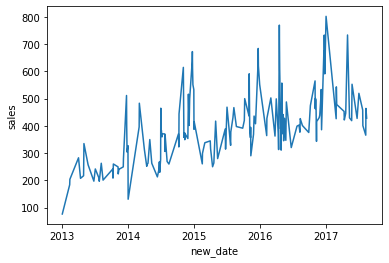

In [12]:
#Time Series plot of the sales data
sns.lineplot(x='new_date',y='sales',data=df,ci=None,estimator='mean')

<AxesSubplot:xlabel='new_date', ylabel='dcoilwtico'>

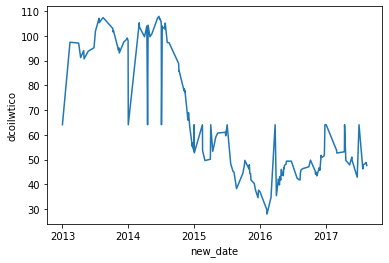

In [123]:
sns.lineplot(x='new_date',y='dcoilwtico',data=df,ci=None,estimator='mean')

You can see from the line graph that the store sales has a positive trend. Since 2013 to 2017, sales increase in year by year.

Then we will categorize values in family and store_nbr in dataset, train and test set.

In [13]:
df['family'].replace(['AUTOMOTIVE', 'HARDWARE', 'LAWN AND GARDEN', 'PLAYERS AND ELECTRONICS'], 'Tools', inplace = True)
df['family'].replace(['BEAUTY', 'LINGERIE', 'LADIESWEAR','PERSONAL CARE','CELEBRATION','MAGAZINES','BOOKS', 'BABY CARE'], 'LifeStyle', inplace = True)
df['family'].replace(['HOME APPLIANCES','HOME AND KITCHEN I', 'HOME AND KITCHEN II','HOME CARE','SCHOOL AND OFFICE SUPPLIES'], 'Home', inplace=True)
df['family'].replace([ 'GROCERY II', 'PET SUPPLIES','SEAFOOD','LIQUOR,WINE,BEER'], 'Food', inplace=True)
df['family'].replace(['DELI', 'EGGS'], 'Daily', inplace=True)

In [14]:
train['family'].replace(['AUTOMOTIVE', 'HARDWARE', 'LAWN AND GARDEN', 'PLAYERS AND ELECTRONICS'], 'Tools', inplace = True)
train['family'].replace(['BEAUTY', 'LINGERIE', 'LADIESWEAR','PERSONAL CARE','CELEBRATION','MAGAZINES','BOOKS', 'BABY CARE'], 'LifeStyle', inplace = True)
train['family'].replace(['HOME APPLIANCES','HOME AND KITCHEN I', 'HOME AND KITCHEN II','HOME CARE','SCHOOL AND OFFICE SUPPLIES'], 'Home', inplace=True)
train['family'].replace([ 'GROCERY II', 'PET SUPPLIES','SEAFOOD','LIQUOR,WINE,BEER'], 'Food', inplace=True)
train['family'].replace(['DELI', 'EGGS'], 'Daily', inplace=True)

In [15]:
test['family'].replace(['AUTOMOTIVE', 'HARDWARE', 'LAWN AND GARDEN', 'PLAYERS AND ELECTRONICS'], 'Tools', inplace = True)
test['family'].replace(['BEAUTY', 'LINGERIE', 'LADIESWEAR','PERSONAL CARE','CELEBRATION','MAGAZINES','BOOKS', 'BABY CARE'], 'LifeStyle', inplace = True)
test['family'].replace(['HOME APPLIANCES','HOME AND KITCHEN I', 'HOME AND KITCHEN II','HOME CARE','SCHOOL AND OFFICE SUPPLIES'], 'Home', inplace=True)
test['family'].replace([ 'GROCERY II', 'PET SUPPLIES','SEAFOOD','LIQUOR,WINE,BEER'], 'Food', inplace=True)
test['family'].replace(['DELI', 'EGGS'], 'Daily', inplace=True)

Prepare data for modelling, in train and test set

In [16]:
#splitting the train dataset into train and test and remove id from both sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.loc[:, train.columns != 'sales'], train['sales'], test_size=0.3, random_state=1)
X_train = X_train.drop(['id'], axis = 1)
X_test = X_test.drop(['id'], axis = 1)
test1 = test1.drop(['id'], axis = 1)

In [17]:
#convert attribute
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# one-hot encode the categorical features
cat_attribs = ['date','family']
full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)], remainder='passthrough')

encoder = full_pipeline.fit(X_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)
test1 = encoder.transform(test1)

After we prep data and run descriptive analysis, next we will start predictive model by 3 approahes (1) Ridge regression with cross validation and tuning (2) GradientBoosting (3) Random Forest, then we will compare the efficiency by Mean Squared Error (MSE)

1. Ridge regression and cross validation

In [56]:
#Ridge regression
from sklearn.linear_model import Ridge
ridg = Ridge(fit_intercept=True, solver='auto', alpha=0.5, normalize=True)

In [57]:
#Cross validation
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

cv_ridge = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(ridg, X_train, y_train, scoring='neg_mean_squared_error', cv=cv_ridge, n_jobs=-1)

# Calculation of mean of MSE for 10 folders
scores = np.absolute(scores)#force it to be positive
print('MSE RidgeCV: %.3f (%.3f)' % (mean(scores), std(scores)))

MSE RidgeCV: 614161.598 (27957.154)


In [20]:
#Tuning Ridge
from sklearn.model_selection import GridSearchCV
from numpy import arange
grid = dict()
grid['alpha'] = arange(0,1,0.1)#tune for 10 times with step at 0.1
search = GridSearchCV(ridg, grid, scoring='neg_mean_squared_error', cv=cv_ridge, n_jobs=-1)
results = search.fit(X_train, y_train)
print('MSE: %.3f' % absolute(results.best_score_))
print('Config: %s' % results.best_params_)

MSE: 560652.051
Config: {'alpha': 0.0}


In [58]:
#Change alpha to 0
ridg_tun = Ridge(fit_intercept=True, solver='auto', alpha=0, normalize=True)
scores_tun = cross_val_score(ridg_tun, X_train, y_train, scoring='neg_mean_squared_error', cv=cv_ridge, n_jobs=-1)
scores_tun = np.absolute(scores_tun)
print('MSE Ridge_tun: %.3f (%.3f)' % (mean(scores_tun), std(scores_tun)))
ridg_tun.fit(X_train,y_train)

MSE Ridge_tun: 560652.051 (26783.795)


Ridge(alpha=0, normalize=True)

In [ ]:
#linear regression
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)
lm_score = lm.score(X_test, y_test)
#MSE
lm_yhat = lm.predict(X_test)
MSE_lm = mean_squared_error(y_test, lm_yhat)

In [120]:
ridg_score = round(ridg_tun.score(X_test,y_test),2)
MSE_ridge = round(mean_squared_error(y_test, ridg_tun.predict(X_test)),2)

In [22]:
#Prediction for real test set (the one we want for submission)
model_ridge_pre = ridg_tun.predict(test1)
print('Predicted :', model_ridge_pre)

Predicted : [ 264.56039119  264.56039119  302.11232613 ... 1090.88246029  455.96651735
  286.98281011]


2. Gradient Boosting

In [68]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [69]:
#getting parameters for gradient boosting
gbr_params = {'n_estimators': 500,
          'max_depth': 3,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
gbr = GradientBoostingRegressor(**gbr_params)

In [70]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, min_samples_split=5,
                          n_estimators=500)

In [93]:
#predict in test set
gbr_yhat= gbr.predict(X_test)
gbr_yhat

array([  38.20118491,   64.33958077,  161.17252815, ...,  122.55176769,
        316.51936669, 1266.40414321])

In [71]:
#calculate accuracy score
print("Gradient Boosting Model Accuracy: %.3f" %gbr.score(X_test, y_test))

Gradient Boosting Model Accuracy: 0.710


In [94]:
MSE_gbr = mean_squared_error(y_test, gbr_yhat)
print("The mean squared error (MSE) on test set: {:.4f}".format(MSE_gbr))

The mean squared error (MSE) on test set: 347081.3990


In [29]:
#Prediction for real test set (the one for submission)
model_gradient_boosting_pre = gbr.predict(test1)
print('Predicted :', model_gradient_boosting_pre)

Predicted : [ 122.55176769  122.55176769  340.95697135 ... 1319.09630681  511.00615635
  112.8660401 ]


3. Random Forest

In [20]:
#run model in train set 
rf = RandomForestRegressor(n_estimators = 100, random_state = 1, max_depth = 15)

In [21]:
#predict in test set
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, random_state=1)

In [22]:
rf_yhat = rf.predict(X_test)

In [23]:
#calculate accuracy score
print("Random Forest Model Accuracy: %.3f" %rf.score(X_test, y_test))

Random Forest Model Accuracy: 0.845


In [24]:
#MSE
MSE_rf = mean_squared_error(y_test, rf_yhat)
print("The mean squared error (MSE) on test set: {:.4f}".format(MSE_rf))

The mean squared error (MSE) on test set: 185513.8784


In [25]:
#Prediction for real test set (for submission)
model_random_forest_pre = rf.predict(test1)
print('Predicted :', model_random_forest_pre)

Predicted : [  29.55321589   29.55321589  143.80742238 ... 1479.43859435  410.58829382
   29.55321589]


Submission

In [29]:
test['prediction'] = model_random_forest_pre

In [30]:
test

,id,date,store_nbr,family,onpromotion,prediction
0,3000888,2017-08-16,1,Tools,0,29.553216
1,3000889,2017-08-16,1,LifeStyle,0,29.553216
2,3000890,2017-08-16,1,LifeStyle,2,143.807422
3,3000891,2017-08-16,1,BEVERAGES,20,2080.227761
4,3000892,2017-08-16,1,LifeStyle,0,29.553216
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,559.107877
28508,3029396,2017-08-31,9,PREPARED FOODS,0,42.583192
28509,3029397,2017-08-31,9,PRODUCE,1,1479.438594
28510,3029398,2017-08-31,9,Home,9,410.588294


In [31]:
submission = pd.DataFrame({'Id': test.id, 'Sales': model_random_forest_pre})
submission.to_csv('submission.csv', index=False)

Visualization of the outcome

In [116]:
lm_score = round(lm_score,2)
gbr_score = round(gbr.score(X_test, y_test),2)
rf_score = round(rf.score(X_test, y_test),2)

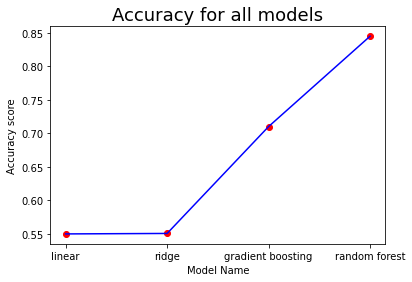

In [86]:
import matplotlib.pyplot as plt
draw_x = ("linear","ridge","gradient boosting","random forest")
draw_y = (lm_score,ridg_score,gbr_score,rf_score)
plt.scatter(draw_x,draw_y,color = "red")
plt.title("Accuracy for all models",fontsize=18)
plt.xlabel("Model Name",fontsize=10)
plt.ylabel("Accuracy score", fontsize=10)
plt.plot(draw_x,draw_y,color = "blue")

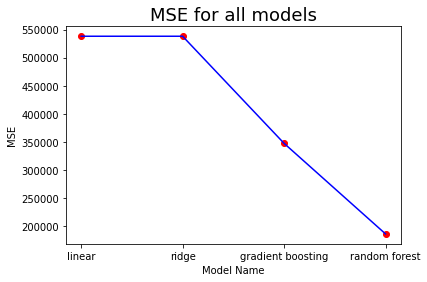

In [99]:
draw_x = ("linear","ridge","gradient boosting","random forest")
draw_z = (MSE_lm,MSE_ridge,MSE_gbr,MSE_rf)
plt.scatter(draw_x,draw_z,color = "red")
plt.title("MSE for all models",fontsize=18)
plt.xlabel("Model Name",fontsize=10)
plt.ylabel("MSE", fontsize=10)
plt.plot(draw_x,draw_z,color = "blue")

In [135]:
from tabulate import tabulate
print(tabulate([["Model Name","linear","ridge","gradient boosting","random forest"],
                ["Accuracy Score",lm_score,ridg_score,gbr_score,rf_score],
                ["MSE",MSE_lm,MSE_ridge,MSE_gbr,MSE_rf]]))

--------------  -----------------  ---------  -----------------  -----------------
Model Name      linear             ridge      gradient boosting  random forest
Accuracy Score  0.55               0.55       0.71               0.85
MSE             538177.6424612665  538178.84  347081.3990477412  185513.8784201336
--------------  -----------------  ---------  -----------------  -----------------
